# Model Building

### Feature Splitting and Scaling

In [23]:
import numpy as np
import pandas as pd

In [24]:
cleaned_df = pd.read_csv('cleaned_data.csv')
cleaned_df.head(3)

,N2O,PP2,PP7,AirT,WFPS25cm,NH4,NO3,Mean_DAF,Season__Spring,Season__Summer,Season__Winter,Vegetation__Others,N_rate__1,Clay__2,Clay__3,Sand__2,Sand__3,SOM__1
0,2.510578,0.000000,0.000000,-2.0,0.666508,2.488761,3.175585,5.558757,0,0,1,0,1,0,0,0,1,0
1,2.361374,0.000000,0.000000,-2.4,0.640608,2.485580,3.176368,5.562603,0,0,1,0,1,0,0,0,1,0
2,2.481391,1.458615,2.265921,0.3,0.728085,2.470780,3.187258,5.592851,0,0,1,0,1,0,0,0,1,0


In [25]:
class SplitData:
    """
        Class for splitting dataset.
        
        Methods:
        -------
        * split_XY: For splitting input dataframe into dataframe of independant features and series of target feature
        * split_TrainTest: For splitting features and label into training and testing datasets
    """ 
    def __init__(self, df):
        self.df = df
    
    def split_Xy(self):
        """
            Function for seperating features and label
            
            Input:
            ------
            X : Dataframe for conversion
            
            Returns:
            --------
            self.X: Dataframe of input features
            self.y: Series of target feature
        """
        self.y = self.df['N2O'] # target
        self.X = self.df.drop(columns=['N2O'], axis=1) # input features
        return self.X, self.y
    
    def split_TrainTest(self, x_=None, y_=None, usevals=False, testsize:float = 0.25, randomstate:int=42):
        """
            Function for splitting features and label into training and testing set
            
            Input:
            ------
            x_: Dataframe of input features
            y_: Series of target feature
            usevals: Boolean - True = Use X and y from split_Xy(), False = input X and y externally
            testsize: Float - Default=0.25 ; Proportion of test data with respect to input dataset
            random_state: Int - Default=42 ; Random seed state
            
            Returns:
            --------
            X_train: Training data of input features
            X_test: Testing data of input features
            y_train: Training data of target feature
            y_test: Testing data of target feature
        """
        from sklearn.model_selection import train_test_split
        
        if usevals: # Using internal variables if set to True
            x_ = self.X
            y_ = self.y
        
        X_train, X_test, y_train, y_test = train_test_split(x_, 
                                                            y_,
                                                            test_size=testsize,
                                                            random_state=randomstate)
        return X_train, X_test, y_train, y_test

In [26]:
# Creating an object for splitting dataframe
split = SplitData(cleaned_df)

### Splitting data into feature dataframe and target

In [27]:
X, y = split.split_Xy()

In [28]:
print(X.shape, y.shape)

(2246, 17) (2246,)


### Splitting data into train and test data

In [29]:
X_train, X_test, y_train, y_test = split.split_TrainTest(usevals=True)

In [30]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1684, 17) (562, 17) (1684,) (562,)


### Feature Scaling

In [36]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

# Scaling training data
X_train_scaled = scalar.fit_transform(X_train)

# Saving the scalar
import joblib
joblib.dump(scalar, 'standard_scalar.sav')

['standard_scalar.sav']

In [38]:
# Scaling test data
test_scalar = joblib.load('standard_scalar.sav')

X_test_scaled = test_scalar.transform(X_test)

### Function for selecting best model among a list of models

In [50]:
# To know the best baseline model
def best_regression_model(models, X, y, nsplits=10, scoring ='neg_mean_squared_error'):
    """
        Inputs:
        ------
        models: list of tuples of model name and model.
                eg:- models=[]
                     models.append(('Linear Regression', LinearRegression()))
                     models.append(('XG Boost', XGBoost()))
        nsplits: Number of splits of KFold Cross validation; int, Default=10
        scoring: Evaluation metric; Default='neg_mean_squared_error'
        randomstate: Random seed state; int, Default=7

        Returns:
        -------
        Prints: Model score mean and standard deviation
        Boxplot: Model scores
    """
    from sklearn.model_selection import cross_val_score, KFold
    
    results=[]
    names = []

    for name, model in models:

        kfold = KFold(n_splits=nsplits)

        cv_results = cross_val_score(model, 
                                     X, y, 
                                     cv=kfold, 
                                     scoring=scoring)
        results.append(cv_results)

        names.append(name)

        msg = f"{name} >> Average score: {round(cv_results.mean(),5)}"
        print(msg)

    # boxplot of models for comparison
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,5))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results, vert=False, showmeans=True)
    ax.set_yticklabels(names)
    plt.show()

In [51]:
# Feeding some base models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = []
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RF', RandomForestRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('LGBM', LGBMRegressor()))

### Finding the best baseline models

KNN >> Average score: -0.07727
SVR >> Average score: -0.07324
RF >> Average score: -0.05725
GB >> Average score: -0.06795
XGB >> Average score: -0.06313
LGBM >> Average score: -0.05748


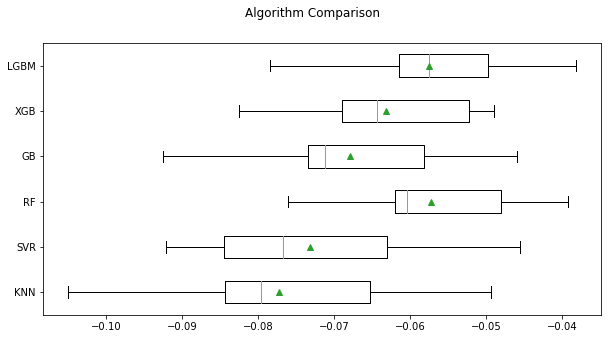

Wall time: 11.7 s


In [52]:
%%time
# Finding the best baseline models
best_regression_model(models, X_train_scaled, y_train)

##### Observations:
* KNN and SVR are performing really bad even after scaling.
* LGBMRegressor and RandomForestRegressor are the top performing models with respect to mean scores. 
* But, we find that even with a bigger range of values, smaller IQR and lower Q3 values, LGBMRegressor has produced maximum scores among all models and tends to be much more stable than RandomForestRegressor when comparing median values.
* Therefore, we will use LGBMRegressor as our initial base model.

### Initial Prediction using a base model

In [72]:
# Using Random Forest Regressor
base_model = LGBMRegressor()
base_model.fit(X_train_scaled, y_train) # model fitting
 
# Predicting the Target variable
y_pred = base_model.predict(X_test_scaled)
print("Predicted values: ", y_pred, "\n")

Predicted values:  [2.10827005 2.104714   2.23714142 2.40831305 2.51152678 2.31448405
 2.21674641 2.17778086 2.20325075 2.75166329 2.73498274 2.23355498
 2.95224381 2.40448555 2.41690132 2.69585948 2.37310036 2.17912489
 2.6995435  2.2799985  3.25827287 2.25775826 3.06445127 2.18514019
 2.20898528 2.83340633 2.6876075  3.14484372 2.34693404 2.4798206
 2.32155485 2.2553786  2.92246918 2.12819281 2.36105591 2.90258197
 3.26641741 2.94763369 2.44724015 2.21666109 2.31764779 2.25073825
 2.09409121 2.76639591 2.48677678 2.49116696 2.23283027 3.06904413
 2.16631818 2.29686357 2.76093014 2.98963155 2.43614893 2.72859055
 2.53394538 2.42925537 2.45366195 2.74768673 3.04381502 2.31382898
 2.20653018 2.17813953 2.29252062 2.47656595 3.00137918 2.40238071
 2.58257672 2.82553795 2.03719488 2.45943505 2.55450579 2.3225927
 1.87151765 2.36740131 2.58443117 2.54197409 2.35260392 2.67383038
 2.33897557 2.57934645 2.32626067 2.44498076 2.3716144  2.32776973
 2.57192393 2.20944915 2.71056067 2.55661556 

In [76]:
# Printing model score
r2 = base_model.score(X_test_scaled, y_test)
print("R2: ",round(r2,5))

# Function to calculate adjusted R2
def adj_r2(x,y,model):
    r2 = model.score(x,y) # calculating r2
    n = x.shape[0] # observations in dataset
    p = x.shape[1] # features in dataset
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

adjustedR2 = adj_r2(X_test_scaled, y_test, base_model)
print("Adjusted R2: ", round(adjustedR2, 5))

R2:  0.59889
Adjusted R2:  0.58635


In [78]:
# Checking how the model fits the training data
print("R2 on training data: ", round(base_model.score(X_train_scaled, y_train), 5))
print("Adjusted R2 on training data: ", round(adj_r2(X_train_scaled, y_train, base_model),5),)

from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(y_test, y_pred))

R2 on training data:  0.87088
Adjusted R2 on training data:  0.86957
MSE:  0.049952963976120784


##### Observations:
* Our best base model overfits the training data by a huge amount. 
* There is also a room for improvement in fitting the data properly. Even the MSE value for the prediction is lower than best value obtained during model comparison.
* Hence, we will require further optimizations inlcuding hyperparameter tuning to fine tune the model.

In [79]:
# Saving the base model to create a minimum viable version of streamlit app
joblib.dump(base_model, 'base_model.sav')

['base_model.sav']

In [80]:
!pip freeze > requirements.txt

# Hyperparameter Tuning

### GridSearch

In [ ]:
# import optuna

# # Create Study object
# study = optuna.create_study(direction="maximize")
# # Optimize the study, use more trials to obtain better result, use less trials to be more cost-efficient
# study.optimize(objective, n_trials=100) # Use more 
# # Print the result
# best_params = study.best_params
# best_score = study.best_value
# print(f"Best score: {best_score}\n")
# print(f"Optimized parameters: {best_params}\n")

# X---------X---------------X-------------------X------------------X-------------------------X-----------------X

# RANDOM_SEED = 42

# # 10-fold CV
# kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
# # Define the helper function so that it can be reused
# def tune(objective):
#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=100)

#     params = study.best_params
#     best_score = study.best_value
#     print(f"Best score: {best_score}\n")
#     print(f"Optimized parameters: {params}\n")
#     return params
# ##################
# # Ridge
# ##################
# def ridge_objective(trial):
#     _alpha = trial.suggest_float("alpha", 0.1, 20)
#     ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED)
#     scores = cross_val_score(
#         ridge, X, y, cv=kfolds,
#         scoring="neg_root_mean_squared_error"
#     )
#     return scores.mean()

# ridge_params = tune(ridge_objective)
# # After tuning it for once, we can copy the best params to create the model without tunning it again
# # ridge_params = {'alpha': 7.491061624529043}
# ridge = Ridge(**ridge_params, random_state=RANDOM_SEED)
# ##################
# # Lasso
# ##################
# def lasso_objective(trial):
#     _alpha = trial.suggest_float("alpha", 0.0001, 1)
#     lasso = Lasso(alpha=_alpha, random_state=RANDOM_SEED)
#     scores = cross_val_score(
#         lasso, X, y, cv=kfolds,
#         scoring="neg_root_mean_squared_error"
#     )
#     return scores.mean()
# lasso_params = tune(lasso_objective)
# # lasso_params = {'alpha': 0.00041398687418613947}
# lasso = Lasso(**lasso_params, random_state=RANDOM_SEED)
# ##################
# # Random Forest
# ##################
# def randomforest_objective(trial):
#     _n_estimators = trial.suggest_int("n_estimators", 50, 200)
#     _max_depth = trial.suggest_int("max_depth", 5, 20)
#     _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
#     _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
#     _max_features = trial.suggest_int("max_features", 10, 50)

#     rf = RandomForestRegressor(
#         max_depth=_max_depth,
#         min_samples_split=_min_samp_split,
#         min_samples_leaf=_min_samples_leaf,
#         max_features=_max_features,
#         n_estimators=_n_estimators,
#         n_jobs=-1,
#         random_state=RANDOM_SEED,
#     )

#     scores = cross_val_score(
#         rf, X, y, cv=kfolds, scoring="neg_root_mean_squared_error"
#     )
#     return scores.mean()

# randomforest_params = tune(randomforest_objective)
# # randomforest_params = {'n_estimators': 180, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 49}
# rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED, **randomforest_params)
# # So on with other models...